The purpose of this file is to use the tutorial on atheism as an example to try eye with lime instead of k-lasso

In [196]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics

In [197]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary') # other average is for multiclass

0.92200232828870776

# explanation

In [198]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [199]:
print(c.predict_proba([newsgroups_test.data[0]]))

[[ 0.282  0.718]]


In [200]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names, feature_selection="lasso_path")

In [201]:
data = "I'm an atheist. THe weather is nice today"
exp = explainer.explain_instance(data, c.predict_proba, num_features=3,
                                 known_features=['Another','contact','john'], C=None)
print('Probability(christian) =', c.predict_proba([data])[0,1])

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


using method lasso_path
Probability(christian) = 0.814


In [202]:
exp.show_in_notebook(text=True)


In [203]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=10,
                                 known_features=['Another','contact','john'], C=None)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


using method lasso_path
Document id: 83
Probability(christian) = 0.44
True class: atheism


In [204]:
exp.show_in_notebook(text=True)

In [512]:
exp.as_list()

[('Posting', -0.1424796513845859),
 ('Host', -0.13069385407777101),
 ('NNTP', -0.10647639591590619),
 ('edu', -0.042105537418536031),
 ('post', -0.012222984539373169),
 ('11', -0.0023742730497222008),
 ('contact', 0.0014191628772503029),
 ('Another', -0.00079259377964967985),
 ('john', -0.00025058171388585846)]

In [513]:
# get rid of posting and host in bag of words representation
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0,1])
tmp = test_vectors[idx].copy()
tmp[0,vectorizer.vocabulary_['Posting']] = 0
tmp[0,vectorizer.vocabulary_['Host']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp)[0,1])
print('Difference:', rf.predict_proba(tmp)[0,1] - rf.predict_proba(test_vectors[idx])[0,1])

Original prediction: 0.43
Prediction removing some features: 0.686
Difference: 0.256


In [195]:
exp.show_in_notebook(text=True)

TypeError: visualize_instance_html() got an unexpected keyword argument 'text'

In [515]:
exp.score

0.98761267143331011

# the problems with current LIME

1. the problem with lasso_path function, so it's really feature selection + model fitting (not a problem)
2. bag of words is really just a set of words, so multiple words in current version doesn't makes a difference (this makes the model easy to interpret)
3. cannot perturb unseen features, all perturbation does is to mask features of the instance (indeed an issue, solved with covariance matrix)
4. feature selection may arbitrarily choose correlated features (this is what eye fixed); due to the way LIME perturbs the data, features are assumed to be occuring independently, so the correlation structure in language is completely lost.
5. line 99 is wrong: though this does not affect result because n=5000, so do not need to change
6. for medicine domain, how to weigh features with different scale? normalize them? that means for the specific instance we want to perturb, we need std and mean of the whole dataset, or we could just use the current solution: using weight times the actual features (for our case, the data are binary, not really a problem)
7. no tests for measuring the difference between g and f: is all just on the training set of perturbations (well, this boils down to can a linear model overfit in high dimension? I guess even if they do, we are just hard to find a simpler model than that: maybe use even less feature? perhaps the benefit of reporting a heldout dataset is to compare between eye and lasso: whether they are faithful to the model)

# some issues and thoughts

The strength of EYE lies in its ability to incorporate feature correlation and expert knowledge into a model. However, in explaining a blackbox model, the perturbation of an instance is acheived by uniform randomly masking parts of the instance, which makes every feature in the interpretable model independent from each other. As such, EYE would not be able to pick up any correlation structure.

To fix this problem, a few solutions seem promising:
1. perturb the data in accordance with the correlation structure and use EYE to fit
2. use lasso to fit and set used features with correlated known features (not really a good idea b/c not only we have to pick a threshold for correlation, but also we lose the dense structure in known features)

Even if this problem is solved, a foundenmental flaw remains: is this credible model truthful to the blackbox model? Consider the following example from LIME paper. The goal is to separate a husky from a wolf. In the data collection step, a mistake was made such that all husky images have snow in the background while it wasn't the case for wolf images. An accurate model could use snow as a discriminative feature, which we certainly don't want. If we use EYE to explain (with solution (1)), the explainer would notice that the prescence of snow and husky are highly correlated, thus attribute weights to husky. In a way, the explainer "corrects" the reason of the model and hides the data collection flaw from the user, which is not acceptable.

A potential solution to this issue is to adopt a different view point. Perhaps eye penalized model gives us a solution to the lasso penalized model if the latter is not credible. Say husky is correlated with snow, then eye penalized model will choose husky over snow which correctly this problem in place. So eye can really be thought of as a corrector model, whenever a new instance comes in, assuming eye penalized model is locally similar to the original model, we can use linear eye model to classify that instance.

Apart from questioning the effectiveness of LIME-eye, I also would like to poke deeper into why we want _credibility_ in the first place. A linear _credible_ model is an accurate model that i) in correlated known features, weights are dense and ii) in correlated unknown features, weights are sparse. Extending it to nonlinear settings: a nonlinear _credible_ model is an accurate model that is linearly _credible_ per instance. If we ignore the reason on human interpretability, a _credible_ model is just a more constrained model, so it wouldn't be more accurate than its unconstrained counterpart given enough data. So we definitely expect a complex model to do better than eye-logistic-regression in our case. A model is no good if it's not accurate, thus trustworthyness is a separate concern. 

Back to the specifics of EYE itself, the square root term really makes efficient optimization hard. Though I'm able to use sgd to train the model, it would converge a lot faster and truly hit 0 if I can use [coordinate descent](http://jocelynchi.com/a-coordinate-descent-algorithm-for-the-lasso-problem) (see my notebook for why derivation for EYE-CD would fail: essentially the square root term makes $x_i$ appear on both sides of the equation, example code for [LASSO-CD](https://github.com/hogefugabar/Lasso)). This could explain the performance difference between sklearn (using cd) and pytorch implementation (gradient methods).

Then another question is can we get rid of the square root term in the equation, I believe we can. Say that the contour intercepts the graph at $1$ and the function in the positive quadrant of the contour is $y$, then we want $y'(1) = -1$ and $y$ is concave (maybe also $y'(0)=0$?). There are infinitely many functions whose contour satisfy these criteria. Maybe we can find one function without the weights tangled together. However, this task is not a priority as the bottleneck right now is how to properly train LIIME-eye, not how to speed up optimization.



# implementation of credible LIME

essentially I just need to implement the eye path function, maybe using coordinate descent for faster convergence: I need to work out the univariate case. 

Recall the objective function of eye is: $eye(x) = \| (1-r) \odot x \|_1 + \sqrt{ \|(1-r) \odot x\|_1^2 + \| r \odot x \|_2^2}$

with x being a single feature, if r=1, then $eye(x) = \| x \|_2$, else $eye(x) = 2 \| x \|_1$, so it just alternate between coordinate descent steps $l_1$ and $l_2$ regression. Note that unlike in previous paper, we are training a regression model instead of logistic regression model here! so use coordinate descent if sgd solution is not exactly zero.

some interesting caveats with pytorch:

1. x.norm(1) vs. x.abs().sum(), the latter learns while the first have trouble when r = 1, very bizarre phenonmena

# explore other contours

In [342]:
import contour_plot
import numpy as np

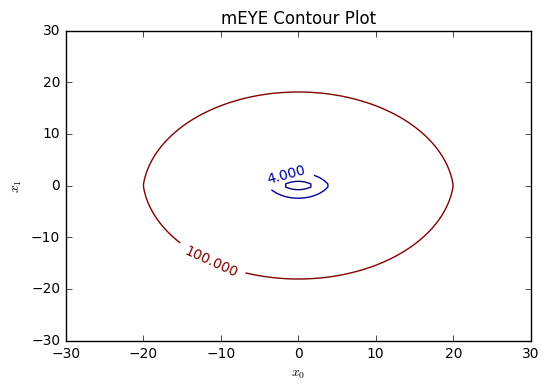

In [417]:
def norm1(a, b):
    return np.abs(a) + np.abs(b)

def norm2sq(a,b):
    return a**2 + b**2

def EYE(x, y):
    # x is known, y unknown
    return np.abs(y) + np.sqrt(x**2 + (np.abs(y))**2)

def mEYE(x, y, rx, ry, beta):
    # x is known, y unknown
    dense = norm2sq(x * rx, y * ry)
    sparse = norm1(x * (1-rx), y * (1-ry))
    return sparse + beta * (dense  + sparse**2)

#contour_plot.drawContour(EYE(contour_plot.X, contour_plot.Y), "EYE")
contour_plot.drawContour(mEYE(contour_plot.X, contour_plot.Y, 1, 0, 0.25), "mEYE", levels=[1, 4, 100])


# generate according to correlation

In [498]:
def cov2corr(C):
    # C is covariance matrix
    Dinv = np.diag(1 / np.sqrt(np.diag(C)))
    return Dinv.dot(C).dot(Dinv)
    
def genCovX(C, n):
    # C is the covariance matrice (assume to be psd)                                                                                                                       
    # n is number of examples                                                                                                                                              
    # if C is None: return np.random.randint(2, size=(n, d)) * 2 / np.sqrt(n)                                                                                              
    d, _ = C.shape
    # Z = np.random.randint(2, size=(n, d)) * 2 / sqrt(n)                                                                                                                  
    Z = np.random.randn(n,d) / np.sqrt(n)
    A = np.linalg.cholesky(C)
    X = Z.dot(A.T)
    # let's translate and normalize to have a probability                                                                                                                  
    X -= X.min()
    X /= X.max()
    # normaize each row so that each row has at least a one (not justified approach, just try to see effect)
    print(X)
    #unX = (X.T/X.max(1)).T
    #print(unX)
    return np.random.binomial(1, X)

def genCorrX(C, n):
    # todo:
    # C is covariance matrix
    d, _ = C.shape
    # convert C to correlation matrix
    corr = cov2corr(C)
    # when it is 1 then output 1
    # when it is -1 output 0
    # else output either 1 or 0 based on the probability
    # also not technically sound
    


In [499]:
C = np.zeros((4,4))
C[:2, :2] = 0.99
C[2:4, 2:4] = 0.99
np.fill_diagonal(C,1)
#np.corrcoef(genCovX(C, 10000).T)
cov2corr(C)

array([[ 1.  ,  0.99,  0.  ,  0.  ],
       [ 0.99,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.99],
       [ 0.  ,  0.  ,  0.99,  1.  ]])

apparently, current gen correlation fails to capture correlation structure. Try groubi to solve this 0-1 linear integer programming (see note for objective here)

# in terms of the running time of models

Currently two broad classes of models are run: mlp and rnn. For MLP, I just used a 5 layer neural network with leaky relu as nonlinearity and dropout as regularization in between. For rnn, I'm using 1 layer GRU. For each model, I run them for 10 epochs, mlp completes in 9 hours (I believe it completes much earlier, the timing function was broken for this version), but the GRU model does not completes before I removed the job (based on what I got, I expect GRU to finish in 50 hours for 10 epochs). In terms of prediction time, MLP would complete evaluation in 25 minutes, while GRU needs 4 hours. The architectures are summarized below:

|model name| train performance | val performance | solver | train time for 10 epoch | evaluation time
|----|----|----|---|---|---
|5 layer mlp | 0.82775 | 0.5003  | adam(lr=0.0204) | < 9 hours | 25 min
|gru | ? | ? | adam | < 50 hours | 4 hours

# TODO:
1. learn a generative model (why assume gaussian, why assume anything? why randomly throwing in points is bad?)
2. try to overfit the data with rnn or mlp by increasing the model size and verify their convergence
3. add in all sorts of tricks to the mlp and rnn baselines: early stopping, batch normalization, etc.
4. use random search in favor of grid search (http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)
5. look into optimizing the model (eg. eliminate python for loop as much as possible, smarter ways to use sparse data (pytorch does not natively support this yet), adam vs. adadelta)
6. understand Cdiff datasets more (283,737, 49,084) for train, (217,793, 49084) for test, (160,447, 49,084) for val, this is for mlp, for gru (122,986, 49,084) for train ...

# a simple example

the purpose of this example is to verify the localness of LIME, does correlation exist on a local level? to that purpose, I just use 2 features: income and age (which are piecewise correlated in my example). In order to fail a global linear classifier, we aim for a hypothetical disease that only happens for people between age 35 to age 45.

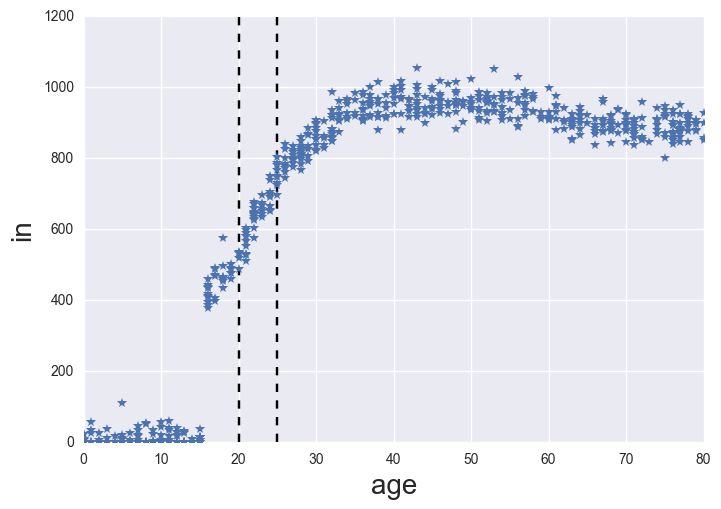

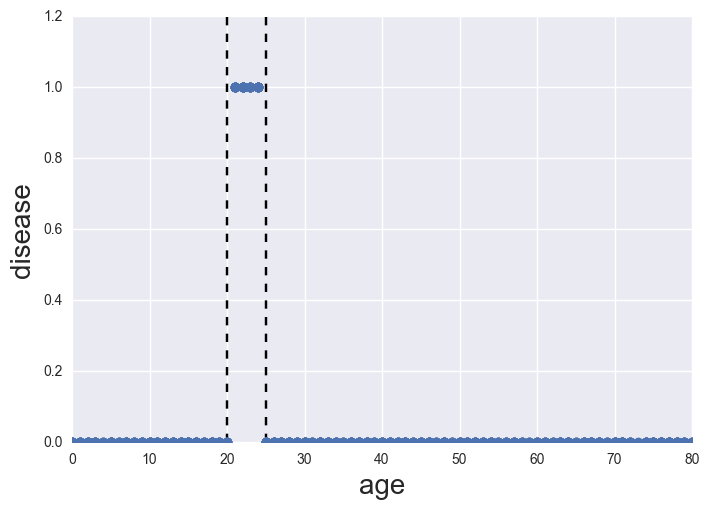

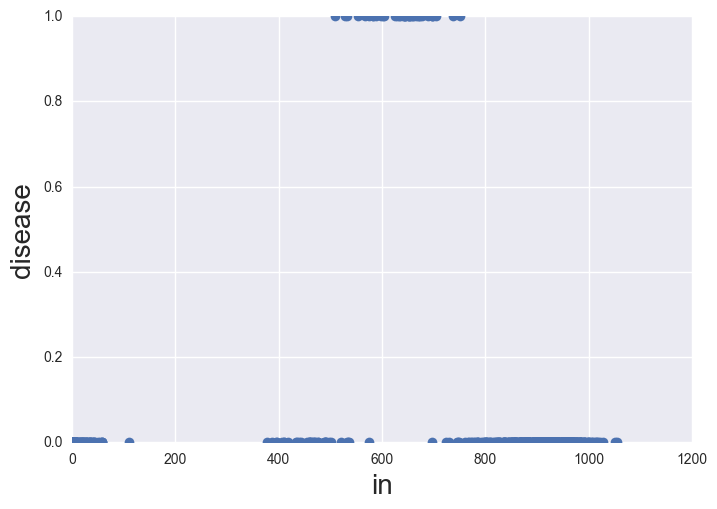

In [514]:
import numpy as np
import seaborn as sns
# example taken from https://smartasset.com/retirement/the-average-salary-by-age
# the relationship between income and age: approximated by piecewise linear function
np.random.seed(1)
age    = [16,  20,  25,  35,  45,  55,  65]
income = [420, 528, 758, 950, 962, 954, 888]
feature_names = ['age', 'in'] # income per week
class_names = ['no disease', 'disease']
#sns.plt.plot(age, income, 'o')

# interpolates the rest
n_samples = 600
age_from = 0
age_to = 81
sample_ages = np.sort(np.random.randint(age_from, age_to, n_samples))
sample_income = np.interp(sample_ages, age, income, left=0, right=income[-1])

# add some noise
#sample_ages = np.array(sample_ages) + np.random.randint(0, 5, n_samples)
sample_income = np.array(sample_income) + np.random.randn(n_samples) * np.sqrt(max(income))
sample_income[sample_income<0] = 0


X = np.vstack((sample_ages, sample_income)).T

# model the disease
age_low = 20
age_high = 25
y = (np.logical_and(X[:,0] > age_low, X[:,0] < age_high)).astype(np.int)

sns.plt.plot(sample_ages, sample_income, '*')
sns.plt.xlabel(feature_names[0], fontsize=20)
sns.plt.ylabel(feature_names[1], fontsize=20)
sns.plt.vlines([age_low, age_high], 0, 1200, linestyle="dashed")
sns.plt.show()

sns.plt.plot(X[:,0], y, "o")
sns.plt.xlabel(feature_names[0], fontsize=20)
sns.plt.ylabel(class_names[1], fontsize=20)
sns.plt.vlines([age_low, age_high], 0, 1.2, linestyle="dashed")
sns.plt.show()

sns.plt.plot(X[:,1], y, "o")
sns.plt.xlabel(feature_names[1], fontsize=20)
sns.plt.ylabel(class_names[1], fontsize=20)
sns.plt.show()

# split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [515]:
import sklearn
import sklearn.ensemble
# the model
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=5) # 200 was wrong
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# report performance
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("random performance %.2f" % ((age_high - age_low) / (age_to - age_from)))
print("actual performance %.2f" % acc)

random performance 0.06
actual performance 0.97


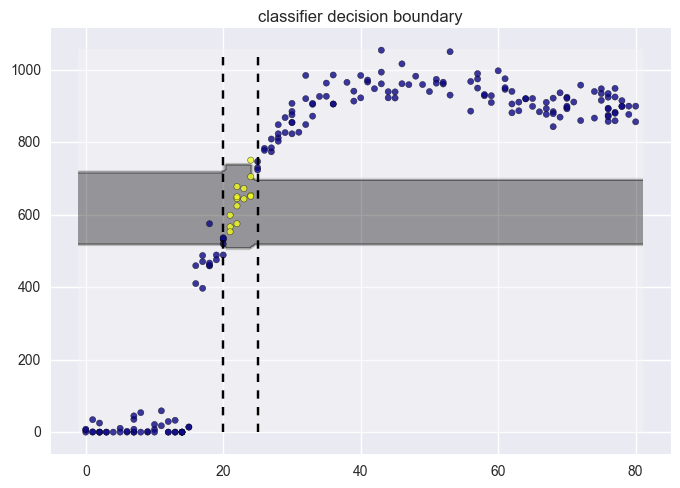

In [516]:
# plot decision boundary
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.vlines([age_low, age_high], y_min, y_max, linestyle="dashed")
sns.plt.contourf(xx, yy, Z, alpha=0.4)
sns.plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.8, cmap=sns.plt.get_cmap('plasma'))
sns.plt.title("classifier decision boundary")
sns.plt.show()

In [517]:
# explain using the explainer: tabular data: 
# question: how do they use the train? 
# answer: they compute frequency for eacch feature independently and binarize based on the explain instance
# question: discretize_continuous=True
# answer: otherwise will perturb independently with gaussian using learned std and mean
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names=feature_names, class_names=class_names,
                                                   categorical_features=None, feature_selection="lasso_path",
                                                   categorical_names=None, discretize_continuous=True,
                                                   discretizer='quartile')

In [518]:
index = 3 # up to 198
exp = explainer.explain_instance(X_test[index], clf.predict_proba, num_features=1, known_features=['age'])
exp.show_in_notebook(show_all=True)
print("got it %s" % "right" if clf.predict([X_test[index]])[0] == y_test[index] else "wrong")

using method lasso_path


got it right


The following list of instances are explained in a not credible manner (chooses income over age):
[3, 10, 31]

with n_estimators=5, num_features=1, lime fails to capture what the data really looks like

In [519]:
np.argwhere(y_test==1)

array([[ 17],
       [ 23],
       [ 31],
       [ 46],
       [ 58],
       [108],
       [148],
       [150],
       [168],
       [169],
       [176],
       [184],
       [185],
       [192]])

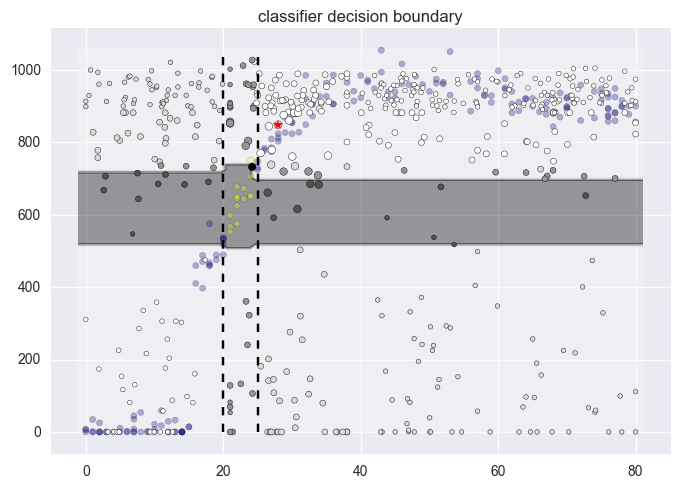

In [520]:
# let's visualize the data learned and more!
n_perturb=500
data, inverse = explainer._LimeTabularExplainer__data_inverse(X_test[index], n_perturb)
scaled_data = (data - explainer.scaler.mean_) / explainer.scaler.scale_

distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1, -1),
            metric='euclidean'
        ).ravel()

def kernel(d, kernel_width=1):                                                   
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

weights = kernel(distances)

# plot decision boundary
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.vlines([age_low, age_high], y_min, y_max, linestyle="dashed")
sns.plt.contourf(xx, yy, Z, alpha=0.4)
sns.plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.3, cmap=sns.plt.get_cmap('plasma'))
sns.plt.title("classifier decision boundary")


# the interpolated points
pt_ms = 30
colors = clf.predict_proba(inverse)[:,1]
sns.plt.plot(inverse[0,0], inverse[0,1], 'r*')
sns.plt.scatter(inverse[:,0], inverse[:,1], s=pt_ms*weights, cmap=sns.plt.get_cmap('Greys'), c=colors)

sns.plt.show()

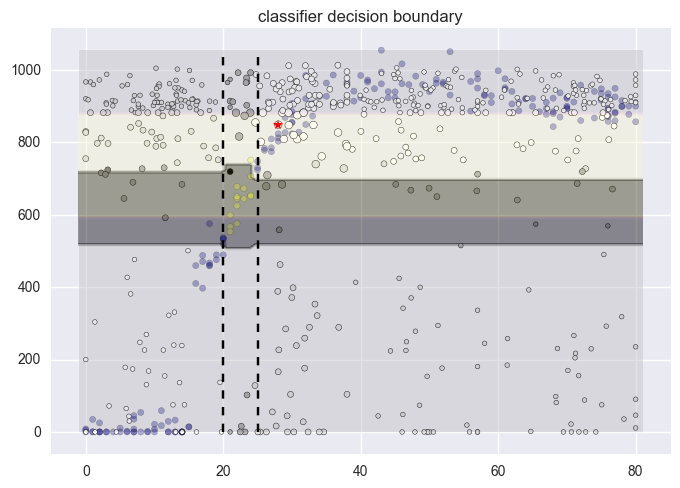

In [522]:
# add in the local function
n_perturb=500
data, inverse = explainer._LimeTabularExplainer__data_inverse(X_test[index], n_perturb)
scaled_data = (data - explainer.scaler.mean_) / explainer.scaler.scale_

distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1, -1),
            metric='euclidean'
        ).ravel()

def kernel(d, kernel_width=1):                                                   
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

weights = kernel(distances)

# plot decision boundary
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.vlines([age_low, age_high], y_min, y_max, linestyle="dashed")
sns.plt.contourf(xx, yy, Z, alpha=0.4)
sns.plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.3, cmap=sns.plt.get_cmap('plasma'))
sns.plt.title("classifier decision boundary")


# the interpolated points
pt_ms = 30
colors = clf.predict_proba(inverse)[:,1]
sns.plt.plot(inverse[0,0], inverse[0,1], 'r*')
sns.plt.scatter(inverse[:,0], inverse[:,1], s=pt_ms*weights, cmap=sns.plt.get_cmap('Greys'), c=colors)

# the local decision function
bias = exp.intercept[1]
constraints = {'x': lambda x: np.ones_like(x).astype(np.bool), 
               'y': lambda y: np.ones_like(y).astype(np.bool)}
local_weight = {'x': 0, 'y':0}
for fn, w in exp.as_list():
    raw = fn.split(' ')
    if len(raw) == 5:
        if feature_names.index(raw[2]) == 0:
            constraints['x'] = lambda x: np.logical_and(x > float(raw[0]), 
                                                        x <= float(raw[4]))
            local_weight['x'] = w
        else:
            constraints['y'] = lambda x: np.logical_and(x > float(raw[0]), 
                                                        x <= float(raw[4]))
            local_weight['y'] = w
    else: # len(raw) == 3
        arg = 'x'+raw[1]+raw[2]
        if feature_names.index(raw[0]) == 0:
            constraints['x'] = lambda x: eval(arg)
            local_weight['x'] = w
        else:
            constraints['y'] = lambda x: eval(arg)    
            local_weight['y'] = w

def localPredict(x):
    weight = np.zeros(x.shape[0])
    weight[constraints['x'](x[:,0])] += local_weight['x']
    weight[constraints['y'](x[:,1])] += local_weight['y']
    return bias + weight

Z = localPredict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.contourf(xx, yy, Z, alpha=0.1, cmap=sns.plt.get_cmap('inferno'))

sns.plt.show()

so in fact this is a non linear classifier in the original space (linear in the interpretable space)

so in order to have local correlation, we just need that [0,1] and [1,0] doesn't appear in the original data or when those cases occur, they are far from the data to explain (e.g., the yellow data in our case). So really in this case local correlation is used instead of global correlation.

for the perturbing example, it's rather just learning a generative model locally!

# a even simpler case

let's consider the line x2=x1

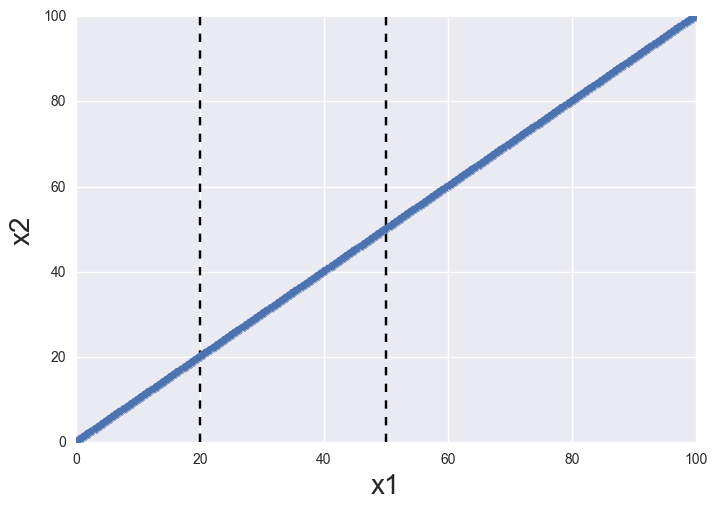

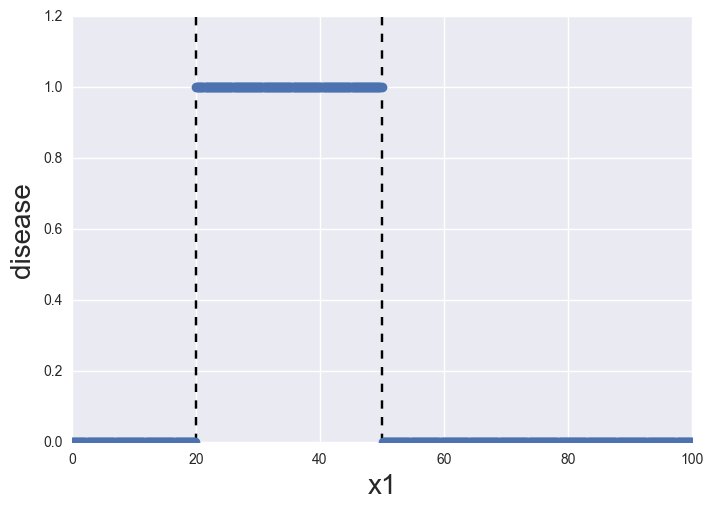

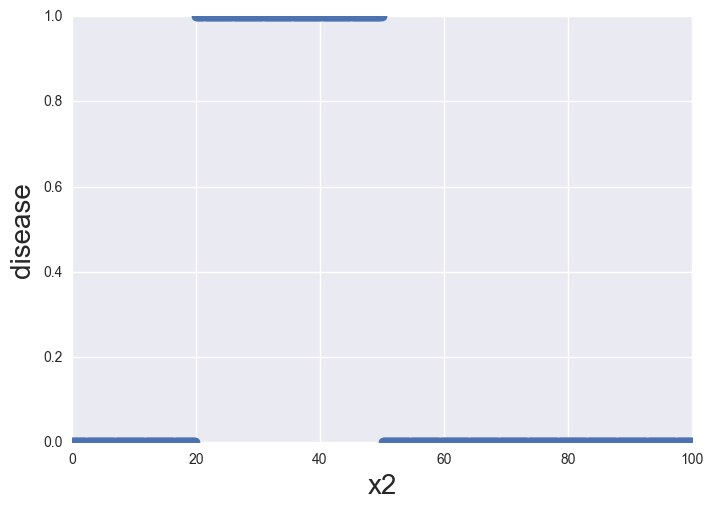

In [523]:
import numpy as np
import seaborn as sns
# example taken from https://smartasset.com/retirement/the-average-salary-by-age
# the relationship between income and age: approximated by piecewise linear function
np.random.seed(1)
feature_names = ['x1', 'x2'] # income per week
class_names = ['no disease', 'disease']

# interpolates the rest
n_samples = 600
sample_x1 = np.linspace(0, 100, n_samples) 
sample_x2 = sample_x1

X = np.vstack((sample_x1, sample_x2)).T

# model the disease
low = 20
high = 50
y = (np.logical_and(X[:,0] > low, X[:,0] < high)).astype(np.int)

sns.plt.plot(sample_x1, sample_x2, '*')
sns.plt.xlabel(feature_names[0], fontsize=20)
sns.plt.ylabel(feature_names[1], fontsize=20)
sns.plt.vlines([low, high], 0, np.max(X[:,1]), linestyle="dashed")
sns.plt.show()

sns.plt.plot(X[:,0], y, "o")
sns.plt.xlabel(feature_names[0], fontsize=20)
sns.plt.ylabel(class_names[1], fontsize=20)
sns.plt.vlines([low, high], 0, np.max(y)+0.2, linestyle="dashed")
sns.plt.show()

sns.plt.plot(X[:,1], y, "o")
sns.plt.xlabel(feature_names[1], fontsize=20)
sns.plt.ylabel(class_names[1], fontsize=20)
sns.plt.show()

# split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [524]:
import sklearn
import sklearn.ensemble
# the model
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=5) # 200 was wrong
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# report performance
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
print("random performance %.2f" % ((high - low) / 100))
print("actual performance %.2f" % acc)

random performance 0.30
actual performance 1.00


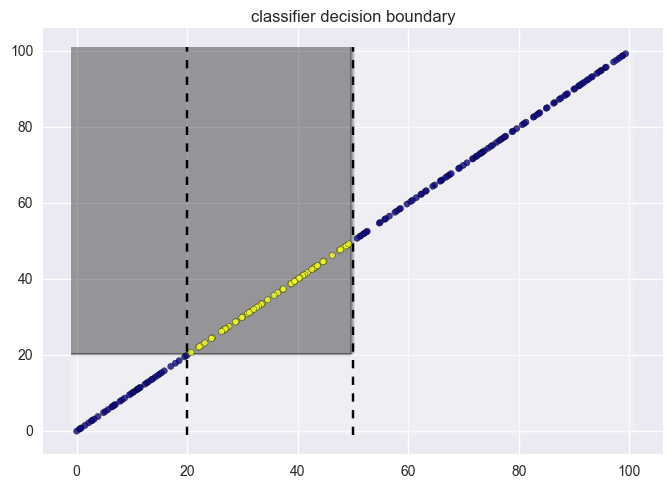

In [525]:
# plot decision boundary
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.vlines([low, high], y_min, y_max, linestyle="dashed")
sns.plt.contourf(xx, yy, Z, alpha=0.4)
sns.plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.8, cmap=sns.plt.get_cmap('plasma'))
sns.plt.title("classifier decision boundary")
sns.plt.show()

In [526]:
# explain using the explainer: tabular data: 
# question: how do they use the train? 
# answer: they compute frequency for eacch feature independently and binarize based on the explain instance
# question: discretize_continuous=True
# answer: otherwise will perturb independently with gaussian using learned std and mean
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names=feature_names, class_names=class_names,
                                                   categorical_features=None, feature_selection="lasso_path",
                                                   categorical_names=None, discretize_continuous=True,
                                                   discretizer='quartile')

In [527]:
index = 0 # up to 198
exp = explainer.explain_instance(X_test[index], clf.predict_proba, num_features=1, known_features=['age'])
exp.show_in_notebook(show_all=True)
print("got it %s" % "right" if clf.predict([X_test[index]])[0] == y_test[index] else "wrong")

using method lasso_path


got it right


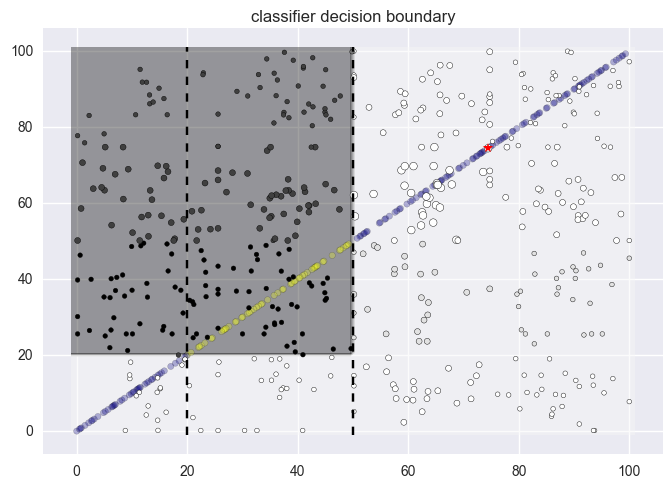

In [528]:
# let's visualize the data learned and more!
n_perturb=500
data, inverse = explainer._LimeTabularExplainer__data_inverse(X_test[index], n_perturb)
scaled_data = (data - explainer.scaler.mean_) / explainer.scaler.scale_

distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1, -1),
            metric='euclidean'
        ).ravel()

def kernel(d, kernel_width=1):                                                   
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

weights = kernel(distances)

# plot decision boundary
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.vlines([low, high], y_min, y_max, linestyle="dashed")
sns.plt.contourf(xx, yy, Z, alpha=0.4)
sns.plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.3, cmap=sns.plt.get_cmap('plasma'))
sns.plt.title("classifier decision boundary")


# the interpolated points
pt_ms = 30
colors = clf.predict_proba(inverse)[:,1]
sns.plt.plot(inverse[0,0], inverse[0,1], 'r*')
sns.plt.scatter(inverse[:,0], inverse[:,1], s=pt_ms*weights, cmap=sns.plt.get_cmap('Greys'), c=colors)

sns.plt.show()

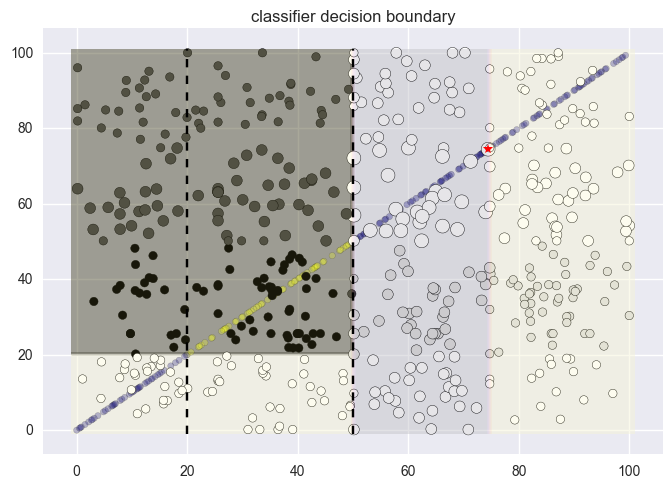

In [529]:
# add in the local function
n_perturb=500
data, inverse = explainer._LimeTabularExplainer__data_inverse(X_test[index], n_perturb)
scaled_data = (data - explainer.scaler.mean_) / explainer.scaler.scale_

distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1, -1),
            metric='euclidean'
        ).ravel()

def kernel(d, kernel_width=1):                                                   
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

weights = kernel(distances)

# plot decision boundary
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.vlines([low, high], y_min, y_max, linestyle="dashed")
sns.plt.contourf(xx, yy, Z, alpha=0.4)
sns.plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.3, cmap=sns.plt.get_cmap('plasma'))
sns.plt.title("classifier decision boundary")


# the interpolated points
pt_ms = 100
colors = clf.predict_proba(inverse)[:,1]
sns.plt.plot(inverse[0,0], inverse[0,1], 'r*')
sns.plt.scatter(inverse[:,0], inverse[:,1], s=pt_ms*weights, cmap=sns.plt.get_cmap('Greys'), c=colors)

# the local decision function
bias = exp.intercept[1]
constraints = {'x': lambda x: np.ones_like(x).astype(np.bool), 
               'y': lambda y: np.ones_like(y).astype(np.bool)}
local_weight = {'x': 0, 'y':0}
for fn, w in exp.as_list():
    raw = fn.split(' ')
    if len(raw) == 5:
        if feature_names.index(raw[2]) == 0:
            constraints['x'] = lambda x: np.logical_and(x > float(raw[0]), 
                                                        x <= float(raw[4]))
            local_weight['x'] = w
        else:
            constraints['y'] = lambda x: np.logical_and(x > float(raw[0]), 
                                                        x <= float(raw[4]))
            local_weight['y'] = w
    else: # len(raw) == 3
        arg = 'x'+raw[1]+raw[2]
        if feature_names.index(raw[0]) == 0:
            constraints['x'] = lambda x: eval(arg)
            local_weight['x'] = w
        else:
            constraints['y'] = lambda x: eval(arg)    
            local_weight['y'] = w

def localPredict(x):
    weight = np.zeros(x.shape[0])
    weight[constraints['x'](x[:,0])] += local_weight['x']
    weight[constraints['y'](x[:,1])] += local_weight['y']
    return bias + weight

Z = localPredict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
sns.plt.contourf(xx, yy, Z, alpha=0.1, cmap=sns.plt.get_cmap('inferno'))

sns.plt.show()

see notes! I guess the justification for perturbing following P(x) is that we don't care about fake points! the obvious downside of learning P(x) is efficiency. It's just hard to fit the training data, so I'm learning another model in effect! Or we could learn a generative model that just preserves correlation and nothing else.